## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\CGANs


## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [3]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    selected_columns = df.iloc[:, [0,1,2,4]]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [4]:
asset_names = returns_df.columns

## TRAINING CGAN

In [5]:
from CGAN1 import CGAN1

for asset_name in returns_df.columns:
    print(f"Training CGAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    # Create WGAN instance for the current asset
    gan = CGAN1(asset_returns, asset_name)
    
    # Train WGAN for this asset
    gan.train()
    gan.generate_scenarios(num_scenarios=20000)
    
    print(f"Finished training CGAN for {asset_name}.\n")

Training CGAN for REEL...
[Epoch 0/3000] [Batch 0/16] [D loss: -0.2401] [G loss: 0.2368]
[Epoch 0/3000] [Batch 10/16] [D loss: -0.1250] [G loss: 0.3586]
[Epoch 1/3000] [Batch 0/16] [D loss: -0.0948] [G loss: 0.3393]
[Epoch 1/3000] [Batch 10/16] [D loss: -0.0340] [G loss: 0.3621]
[Epoch 2/3000] [Batch 0/16] [D loss: -0.0831] [G loss: 0.2405]
[Epoch 2/3000] [Batch 10/16] [D loss: -0.2896] [G loss: 0.3424]
[Epoch 3/3000] [Batch 0/16] [D loss: 0.0997] [G loss: 0.3468]
[Epoch 3/3000] [Batch 10/16] [D loss: -0.0573] [G loss: 0.3173]
[Epoch 4/3000] [Batch 0/16] [D loss: -0.0609] [G loss: 0.3394]
[Epoch 4/3000] [Batch 10/16] [D loss: -0.1580] [G loss: 0.5560]
[Epoch 5/3000] [Batch 0/16] [D loss: -0.2108] [G loss: 0.5559]
[Epoch 5/3000] [Batch 10/16] [D loss: -0.0609] [G loss: 0.2836]
[Epoch 6/3000] [Batch 0/16] [D loss: -0.1351] [G loss: 0.5388]
[Epoch 6/3000] [Batch 10/16] [D loss: -0.0469] [G loss: 0.5726]
[Epoch 7/3000] [Batch 0/16] [D loss: 0.0302] [G loss: 0.5019]
[Epoch 7/3000] [Batch 10

## RESULTS

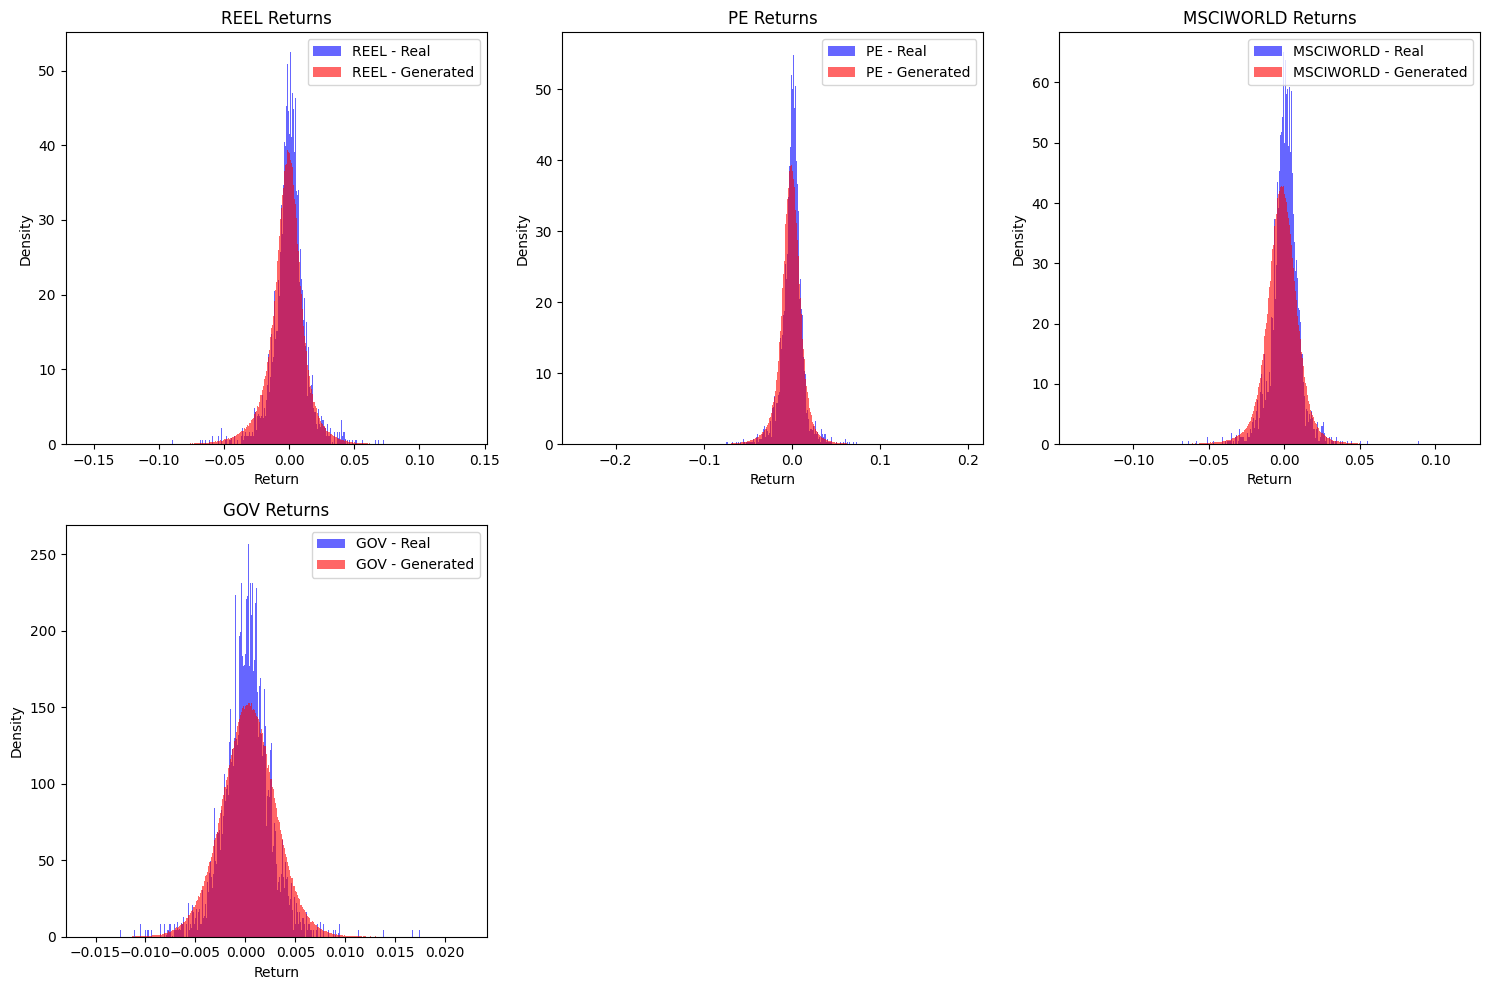


📊 Return Statistics Summary:
                Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
          REEL - Real  0.000193 0.012916 -0.270455  4.969021  -0.051644
     REEL - Generated -0.001908 0.014607 -0.471506  4.448300  -0.055453
            PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
       PE - Generated -0.001169 0.014293 -0.418482  8.191856  -0.054307
     MSCIWORLD - Real  0.000283 0.009887 -0.226726  7.359869  -0.037021
MSCIWORLD - Generated -0.001549 0.011779 -0.335027  4.954125  -0.043568
           GOV - Real  0.000183 0.002449 -0.034370  4.018610  -0.008100
      GOV - Generated  0.000317 0.002778 -0.016731  0.590956  -0.007369



═══════════════════════════
║  ANALYZING ASSET: REEL  ║
═══════════════════════════

Variance of Real Data: 0.000167
Variance of Generated Data: 0.000169
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.276380
Mean Pairwise Distance (Generated): 0.267478
✅ Generated samples are reasonably di

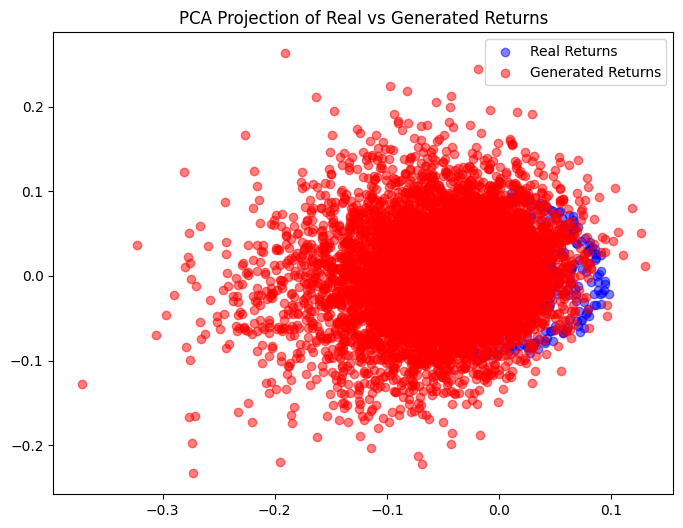

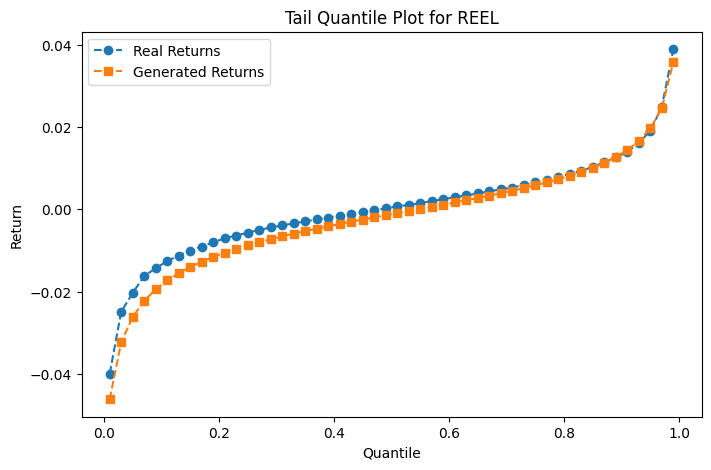


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════


📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 5.593562
Mean Distance: 0.002018
Median Distance: 0.000314
Standard Deviation: 0.025461


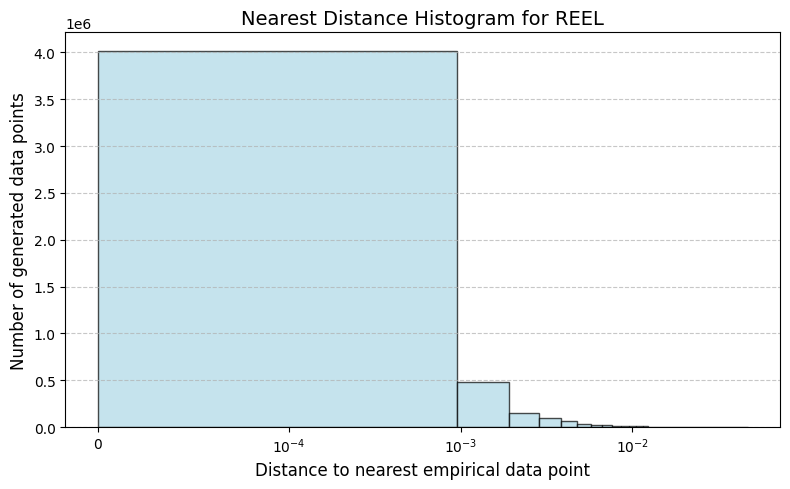


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

📊 Wasserstein Distance for REEL: 0.002166


═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Variance of Real Data: 0.000162
Variance of Generated Data: 0.000155
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.268750
Mean Pairwise Distance (Generated): 0.252311
✅ Generated samples are reasonably diverse


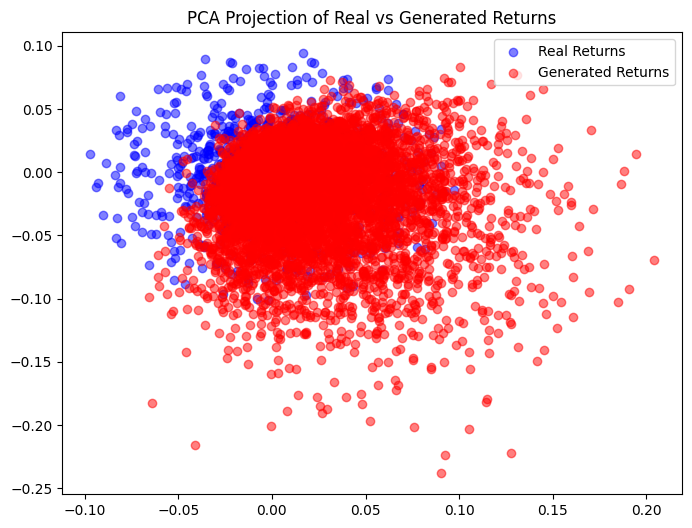

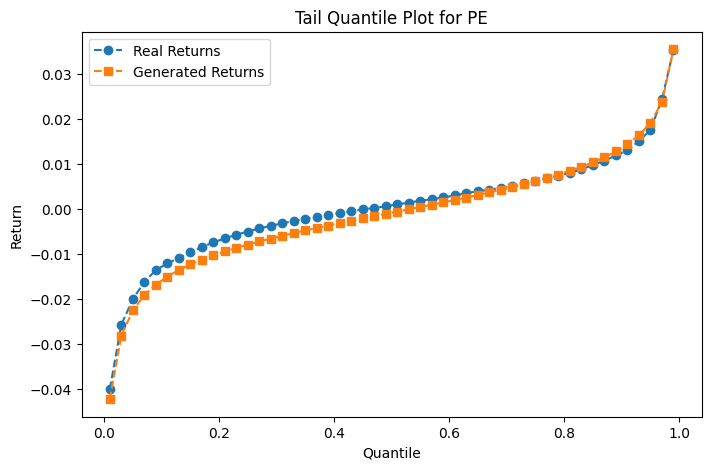


══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: PE  ║
══════════════════════════════════════════════


📊 Distance Summary for PE:
Min Distance: 0.000000
Max Distance: 13.772834
Mean Distance: 0.002962
Median Distance: 0.000312
Standard Deviation: 0.063818


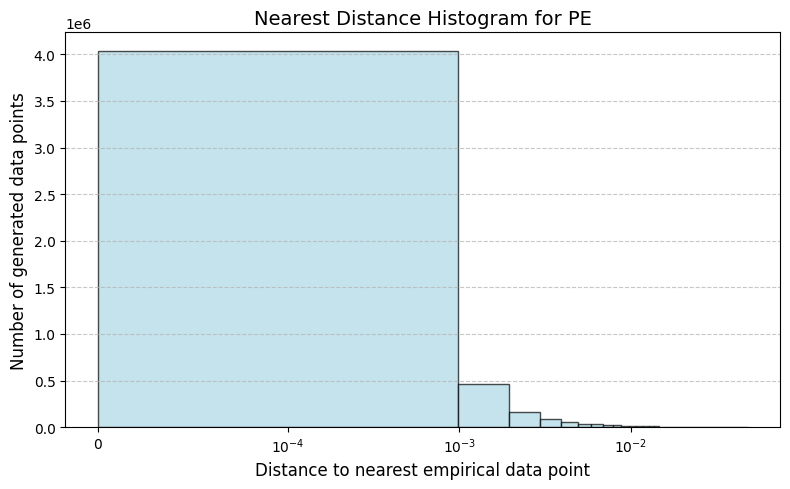


════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: PE  ║
════════════════════════════════════════

📊 Wasserstein Distance for PE: 0.001828


════════════════════════════════
║  ANALYZING ASSET: MSCIWORLD  ║
════════════════════════════════

Variance of Real Data: 0.000098
Variance of Generated Data: 0.000100
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.211255
Mean Pairwise Distance (Generated): 0.206293
✅ Generated samples are reasonably diverse


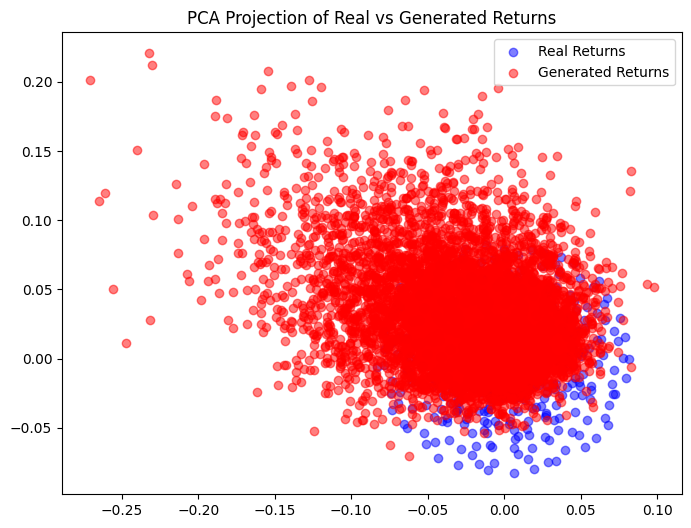

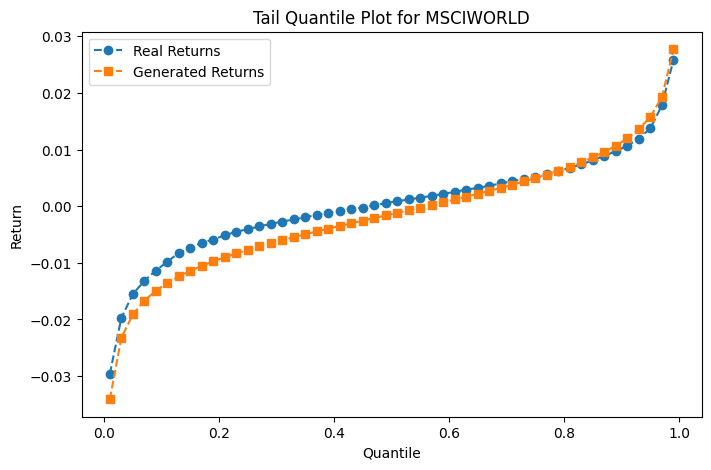


═════════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: MSCIWORLD  ║
═════════════════════════════════════════════════════


📊 Distance Summary for MSCIWORLD:
Min Distance: 0.000000
Max Distance: 6.319921
Mean Distance: 0.002006
Median Distance: 0.000330
Standard Deviation: 0.028015


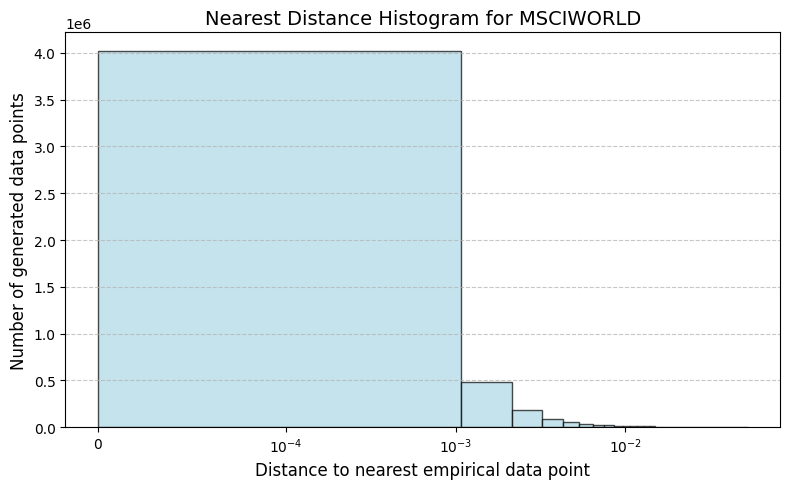


═══════════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: MSCIWORLD  ║
═══════════════════════════════════════════════

📊 Wasserstein Distance for MSCIWORLD: 0.002366


══════════════════════════
║  ANALYZING ASSET: GOV  ║
══════════════════════════

Variance of Real Data: 0.000006
Variance of Generated Data: 0.000006
✅ Generated Data Shows Reasonable Variance
Mean Pairwise Distance (Real): 0.054322
Mean Pairwise Distance (Generated): 0.053177
✅ Generated samples are reasonably diverse


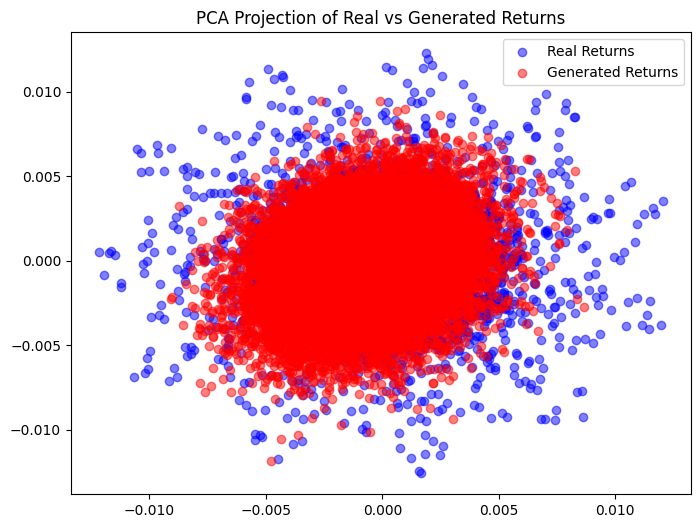

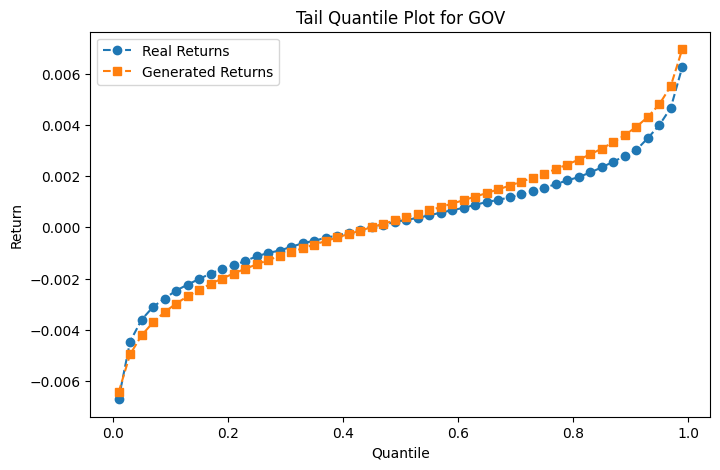


═══════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: GOV  ║
═══════════════════════════════════════════════


📊 Distance Summary for GOV:
Min Distance: 0.000000
Max Distance: 2.308379
Mean Distance: 0.001187
Median Distance: 0.000364
Standard Deviation: 0.005994


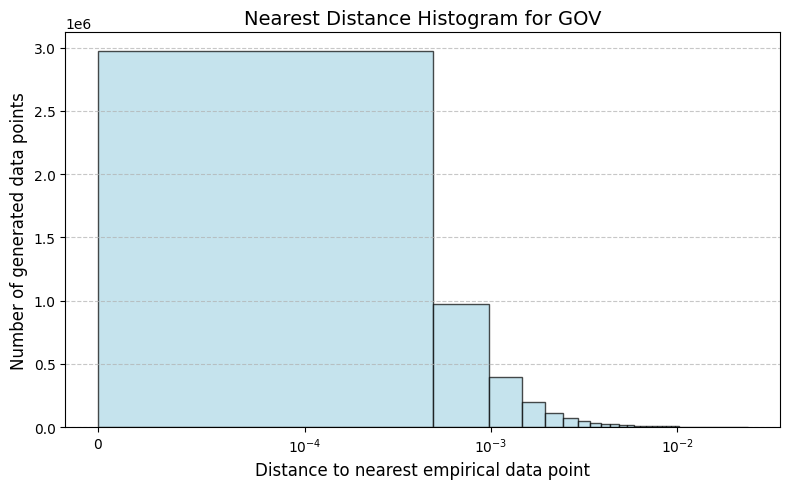


═════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: GOV  ║
═════════════════════════════════════════

📊 Wasserstein Distance for GOV: 0.000424



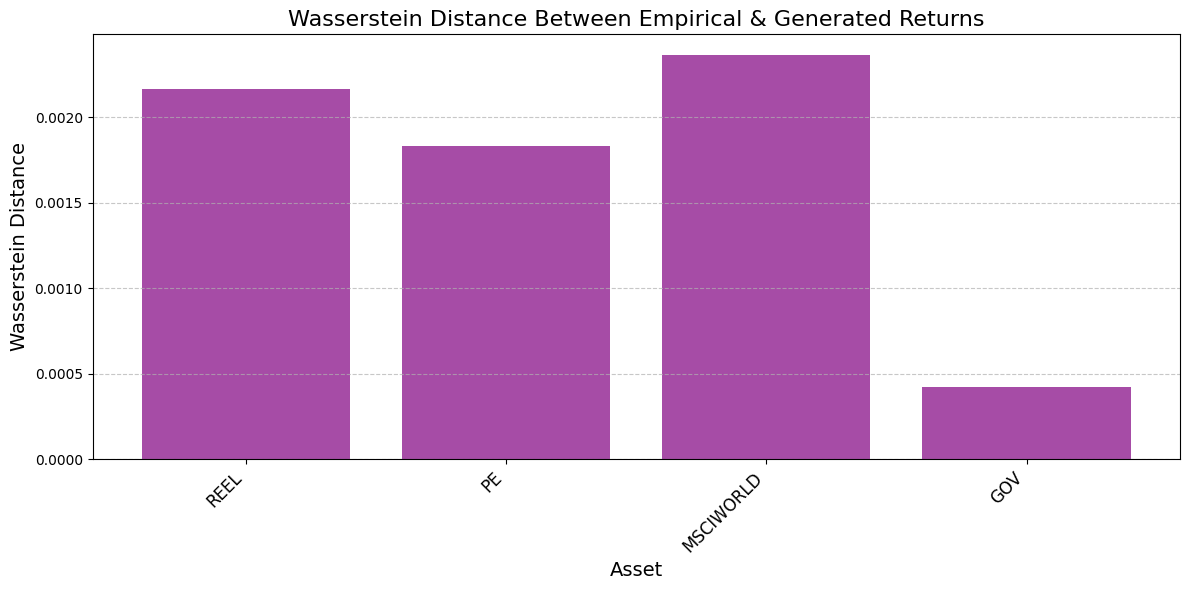

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=True, quarterly=True)

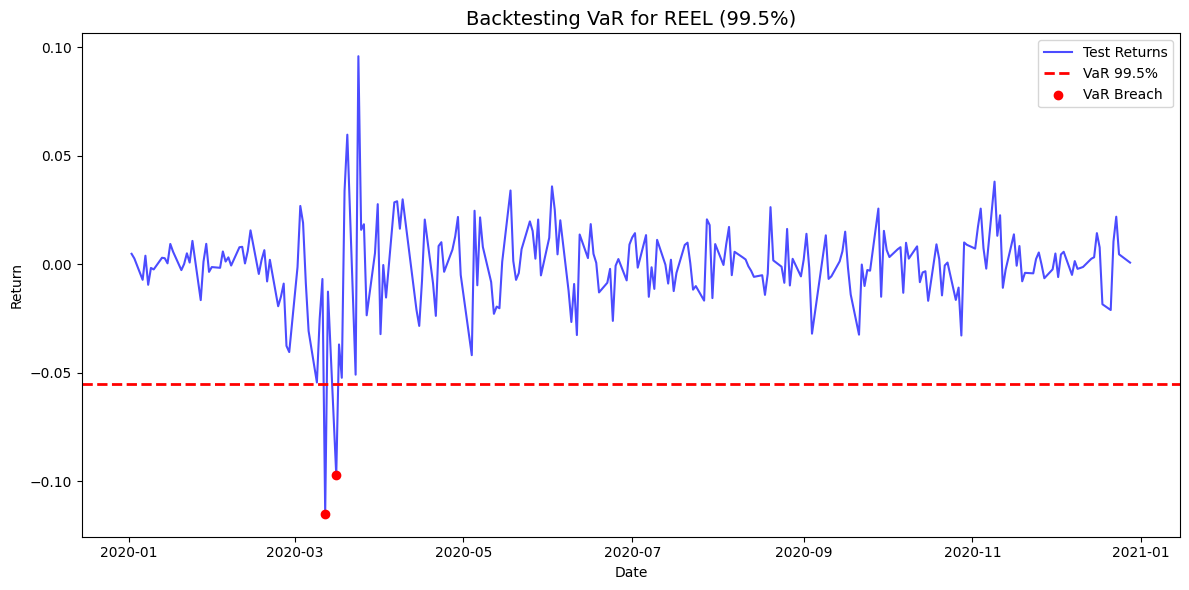


📊 VaR Backtesting Summary for REEL:
VaR 99.5% threshold: -0.055190
Failures (breaches below VaR): 2 times

📊 VaR Backtesting Results for REEL

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 0.3703
📊 p-value: 0.542826
🚦 Test Conclusion: ✅ Passed (p > 0.1) - No significant failure pattern detected 🎉

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 23.2972
📊 p-value: 0.000001
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 23.6675
📊 p-value: 0.000007
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.014880
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.014880
🚦 A higher value is worse.

Distribution Tests for REEL
Overall Moments Comparison:
Generated -> Mean: -0.0019, Std: 0.0146, Skewness: -0.4660
Empirical -> Mean: 0.0002, Std: 

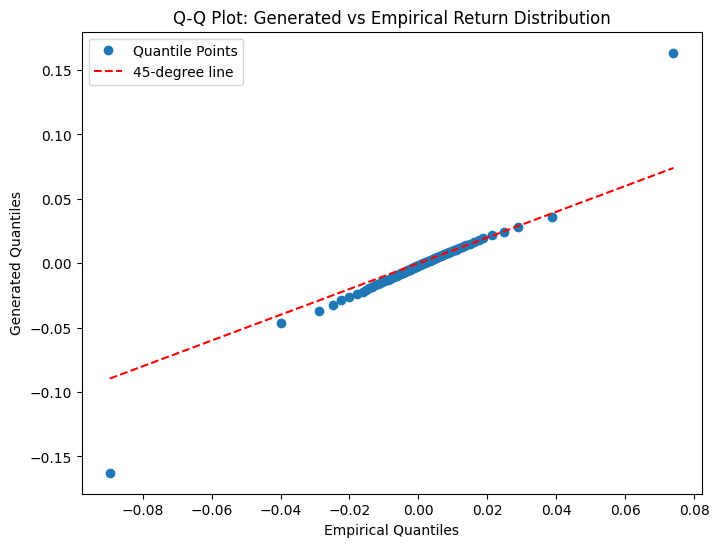


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 4.291203
Overall Mean Empirical Excess Kurtosis: 4.969059015521381
Difference (Generated - Empirical): -0.6778559935182074
Interpretation: The generated distribution's tail heaviness is close to the empirical benchmark.


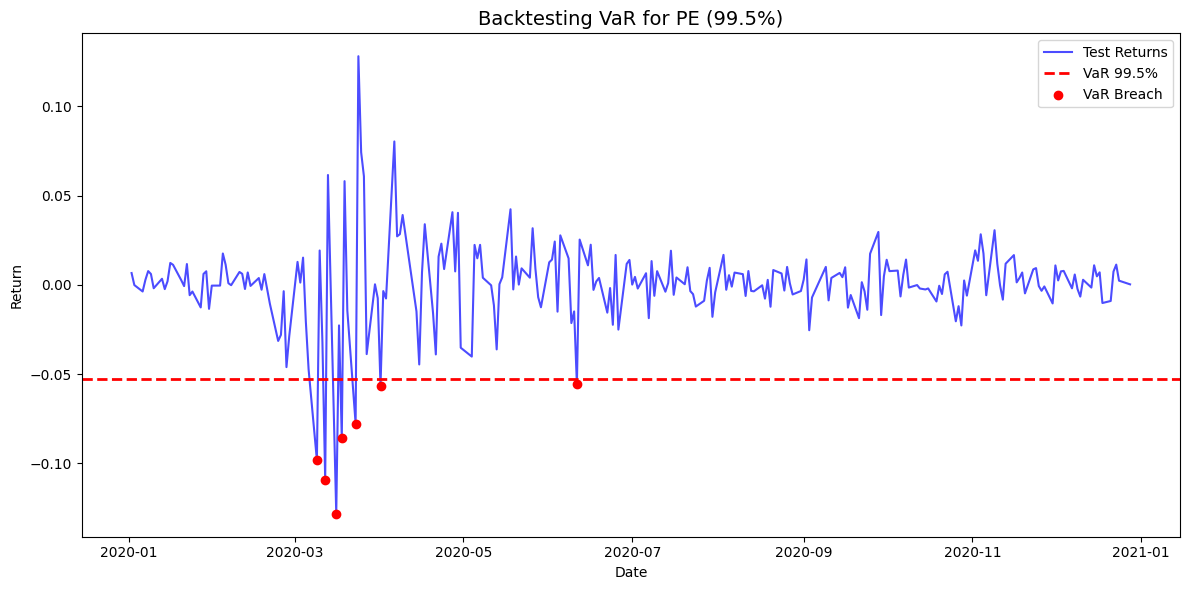


📊 VaR Backtesting Summary for PE:
VaR 99.5% threshold: -0.052507
Failures (breaches below VaR): 7 times

📊 VaR Backtesting Results for PE

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 12.6596
📊 p-value: 0.000374
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 63.8599
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 76.5194
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.046242
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.046242
🚦 A higher value is worse.

Distribution Tests for PE
Overall Moments Comparison:
Generated -> Mean: -0.0012, Std: 0.0140, Skewness: -0.3832
Empirical -> Mean: 0.0002, Std: 0.0127, Skewne

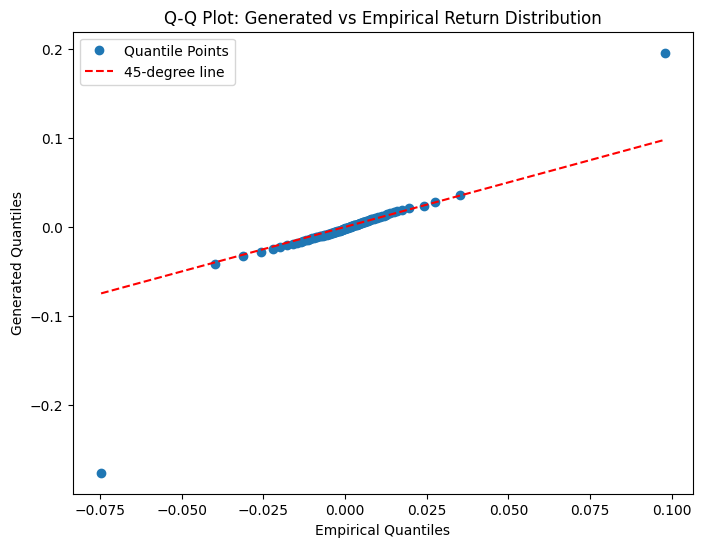


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 7.47262
Overall Mean Empirical Excess Kurtosis: 6.380429483234719
Difference (Generated - Empirical): 1.0921905271412573
Interpretation: The generated distribution exhibits significantly heavier tails than the empirical data.


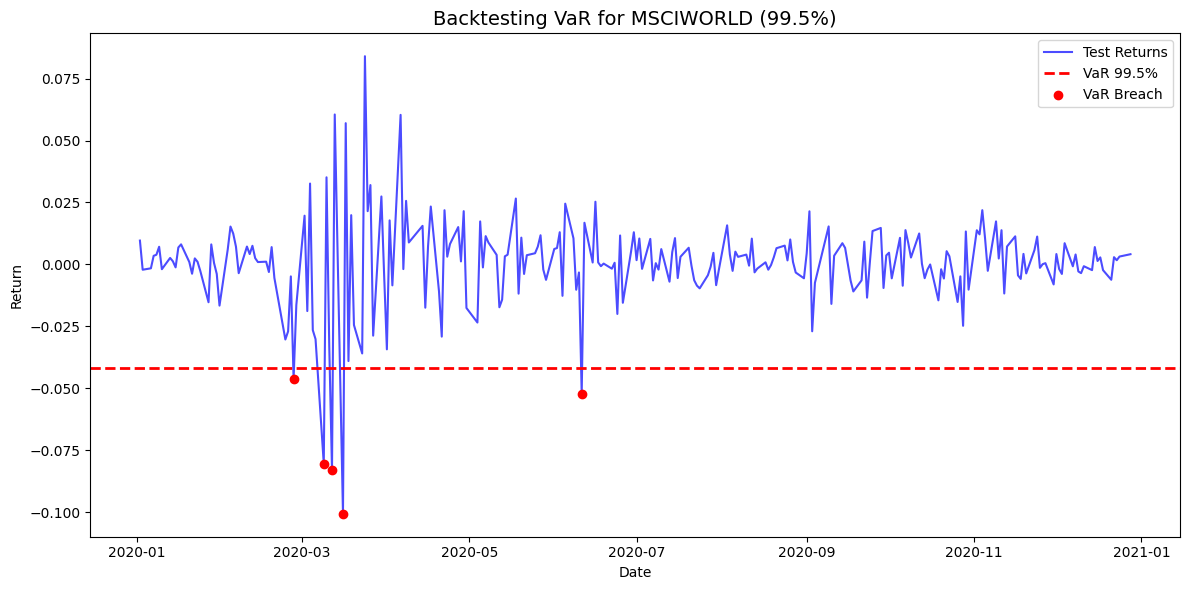


📊 VaR Backtesting Summary for MSCIWORLD:
VaR 99.5% threshold: -0.041988
Failures (breaches below VaR): 5 times

📊 VaR Backtesting Results for MSCIWORLD

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 6.3593
📊 p-value: 0.011677
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 49.0196
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 55.3789
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.034989
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.034989
🚦 A higher value is worse.

Distribution Tests for MSCIWORLD
Overall Moments Comparison:
Generated -> Mean: -0.0015, Std: 0.0115, Skewness: -0.3113
Empirical -> Mean: 0.0003,

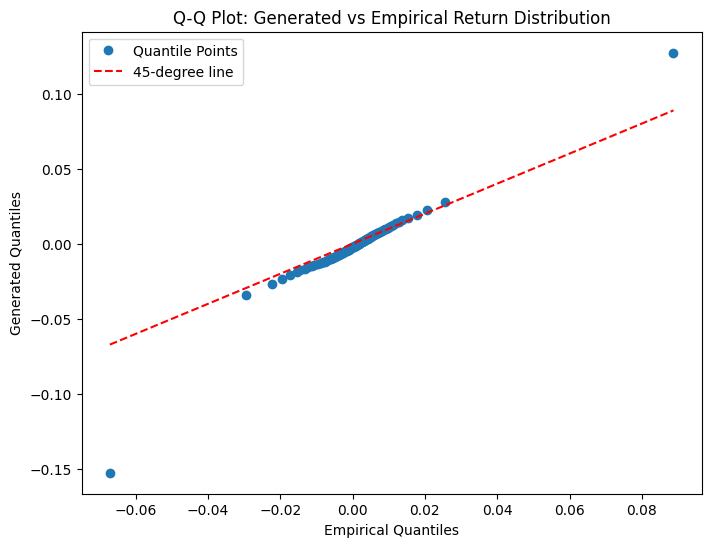


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 4.6174207
Overall Mean Empirical Excess Kurtosis: 7.35992278471412
Difference (Generated - Empirical): -2.742502111343759
Interpretation: The generated distribution exhibits significantly lighter tails than the empirical data.


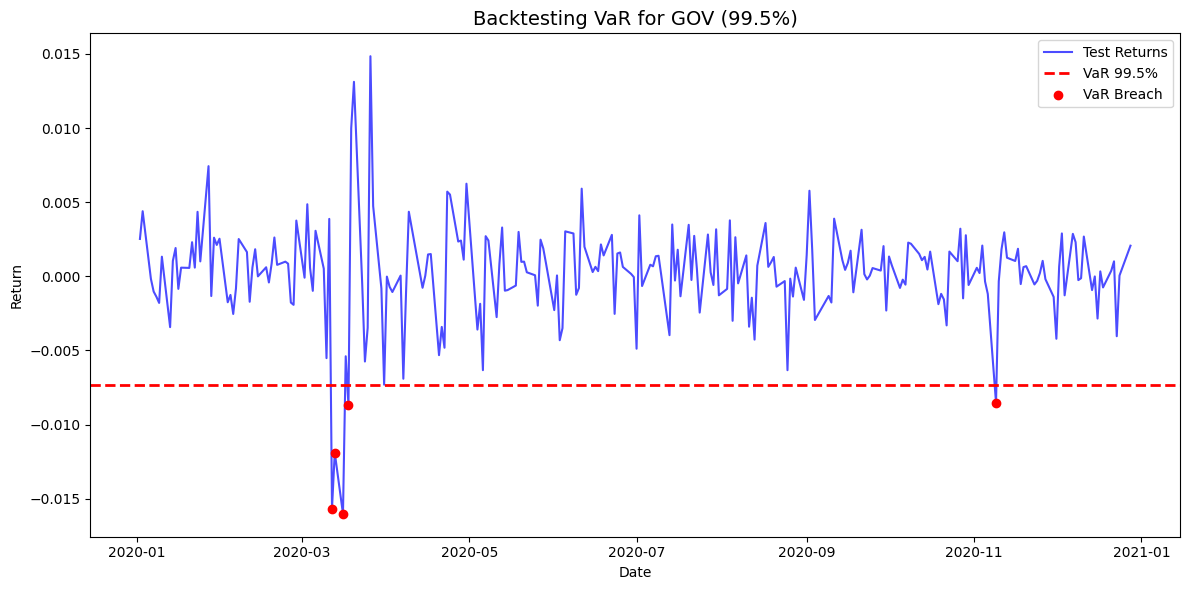


📊 VaR Backtesting Summary for GOV:
VaR 99.5% threshold: -0.007343
Failures (breaches below VaR): 5 times

📊 VaR Backtesting Results for GOV

🔍 Kupiec Proportion of Failures (POF) Test
📝 Likelihood Ratio (LR_pof): 6.3593
📊 p-value: 0.011677
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR model may be misspecified ⚠️

🔍 Christoffersen Independence Test
📝 Likelihood Ratio (LR_ind): 49.0196
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️

🔍 Joint (Conditional Coverage) Test
📝 Joint Likelihood Ratio (LR_joint): 55.3789
📊 p-value: 0.000000
🚦 Test Conclusion: ❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️

🔍 Lopez Average Loss
📝 Average Lopez Loss: 0.032255
🚦 Lower values indicate fewer or less severe violations.

🔍 Balanced SCR Loss
📝 Loss: 0.032255
🚦 A higher value is worse.

Distribution Tests for GOV
Overall Moments Comparison:
Generated -> Mean: 0.0003, Std: 0.0028, Skewness: -0.0182
Empirical -> Mean: 0.0002, Std: 0.0024, Skewn

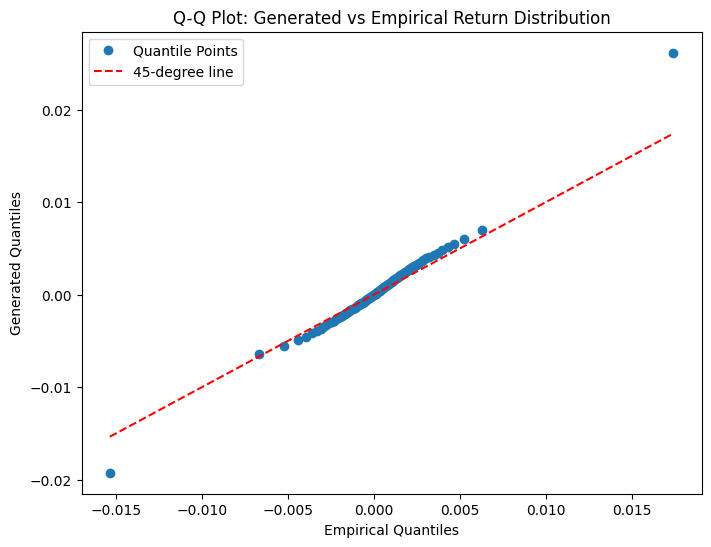


Assessing Fat Tails via Rolling Windows (Excess Kurtosis Comparison)...
Overall Mean Generated Excess Kurtosis: 0.59394264
Overall Mean Empirical Excess Kurtosis: 4.018642134505793
Difference (Generated - Empirical): -3.424699492293879
Interpretation: The generated distribution exhibits significantly lighter tails than the empirical data.


In [7]:
for asset_name in returns_df.columns:
    generated_returns = load_generated_returns(asset_name, test=True)
    failures = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name)
    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=None, asset_name=asset_name, generated_returns=generated_returns)
    perform_distribution_tests(generated_returns=generated_returns, empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)
